# Simple greedy policy

This simple greedy policy ($\Pi_{SG}$) tries to play game with the best action possible in a given moment with minimal random steps. We are going to look at following metrics:
 - $\mathbb{E}(X)=\frac{76}{15} \approx 5.06666$ - expected value when all cards are unknown
 - $\mathbb{E}(X_t) \in [-2, 12]$ - expected value of all _unknown_ cards at time $t$
 - $V(\cdot) \in [-2, 12]$ - value of a card
 - $V(discard\ pile)$ - value of top card in discard pile
 - $V(drawn\ card)$ - value of a drawn card
 - $\max_{x \in \mathcal{B}}V(x)$ - highest card value on the board (board is 12 cards in front of each player)
   - if card is not turned i.e. unknown value $V(x) = \mathbb{E}(X_t)$ 
 - $\mathcal{R_i} \in [0,12]$ - number of remaining (_unknown_) cards on $i$-th player's board

## Policy flow
1. draw a card from discard pile ($V(discard\ pile)$) or deck $\mathbb{E}(X_t)$, which one is lower
2. replace card with the highest difference between drawn card and any card on the board, unknown cards has value $\mathbb{E}(X_t)$, i.e. $$\max_{x\in\mathcal{B}}\big[V(x) - V(drawn\ card)\big]$$ If more cards have the same value, pick one of them at random.
3. repeat till all cards are turned or someone else ended the game

In [1]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt 

from skyjo.environment import PlayersBoard, Deck, DiscardPile, EXPECTED_VALUE
from skyjo.policies.random_policy import RandomPolicy
from skyjo.policies.greedy_policy import GreedyPolicy

In [10]:
def game(expected_value=EXPECTED_VALUE) -> float:
    deck = Deck()
    discard_pile = DiscardPile()
    
    discard_pile.discard(deck.draw())
    board = PlayersBoard([deck.draw() for _ in range(12)])
    
    policy = GreedyPolicy(board, deck, discard_pile, expected_value=expected_value)
    round = 0
    while not board.is_finished():
        card, position = policy.turn()
        discard_pile.discard(deck.draw())
        round += 1

    return board.value()

In [11]:
n = 10 ** 4
x = np.array([game() for _ in range(n)])
avg_scores = np.cumsum(x) / np.arange(1, n + 1)

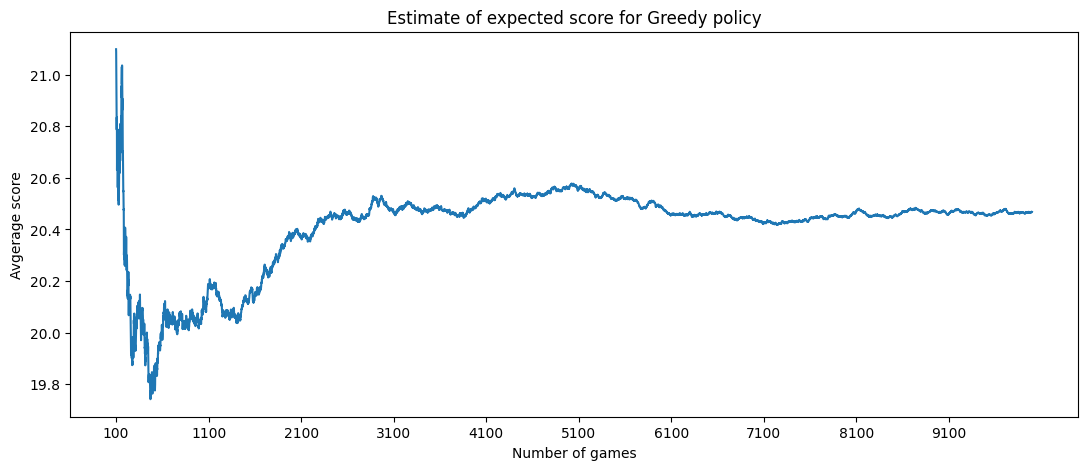

In [12]:
plt.figure(figsize=(13, 5))
plt.title("Estimate of expected score for Greedy policy")
plt.xlabel("Number of games")
plt.ylabel("Avgerage score")
plt.xticks(np.arange(100, n + 100, step=n / 10))
plt.plot(np.arange(100, n), avg_scores[100:], label="Empirical avgerage outcome")
# plt.hist(x, orientation="horizontal", bins=15)
plt.show()

## Expected score
Card drawn at random has probability $p = 7/15$ of being value above expected value $\mathbb{E}(X)$ i.e. value 6-12 and $q=1-p=8/15$ of being bellow the expected value i.e. -2-5. Let's denote values below average $A$ with $\mathbb{E}(A) = \frac{13}{8}$ and values above average $B$ with $\mathbb{E}(B) = 9$.

The Geedy decision flow forms a Markov chain, at each round a card on board is either replaced with new lower value than expected or new card is reviled. If card is replaced we know the new value is going to be below average with $\mathbb{E}(A)$. If card is reviled it's value can be anything between -2-12, and therefore, expected value is $\mathbb{E}(X)$.
 - with probability $q$ discard pile card is below average $A$, then the card is accepted and replaced with $\mathbb{E}(A)$
 - with probability $pq$ card from deck pile is below average $A$, then the card is accepted and replaced with $\mathbb{E}(A)$
 - with probability $p^2$ both discard and deck cards are above average, then new card is reviled with $\mathbb{E}(X)$

Therefore, on the first round, the expected value of new card being turned or old card being replaced is 
$$p^2 \mathbb{E}(X) + (pq + q)\mathbb{E}(A) = p^2 \mathbb{E}(X) + (1 - p^2)\mathbb{E}(A) \approx 2.374$$

For further rounds the explicit calculations of expected value get a bit messy, so we will relly on empirical calculations.

In [41]:
def score_round(round=1, policy_exp=EXPECTED_VALUE):
    deck = Deck()
    discard_pile = DiscardPile()
    
    discard_pile.discard(deck.draw())
    board = PlayersBoard([deck.draw() for _ in range(12)])
    
    policy = GreedyPolicy(board, deck, discard_pile, policy_exp)
    
    for i in range(round):
        card, position = policy.turn()
        discard_pile.discard(deck.draw())

        if board.is_finished():
            break

    return sum(v for v in board.visible_board if v is not None)


In [14]:
m = 10000
print(f"Expected score for the first round: {sum([score_round() for _ in range(m)]) / m}")

Expected score for the first round: 2.3947


In [15]:
m = 10000
print(f"Expected score for the first two rounds: {sum([score_round(2) for _ in range(m)]) / m}")

Expected score for the first two rounds: 4.0273


In [47]:
m = 10000
x = {
    k: [sum([score_round(i, k + 0.1) for _ in range(m)]) / m for i in range(1, 25)]
    for k in range(2, 6)
}

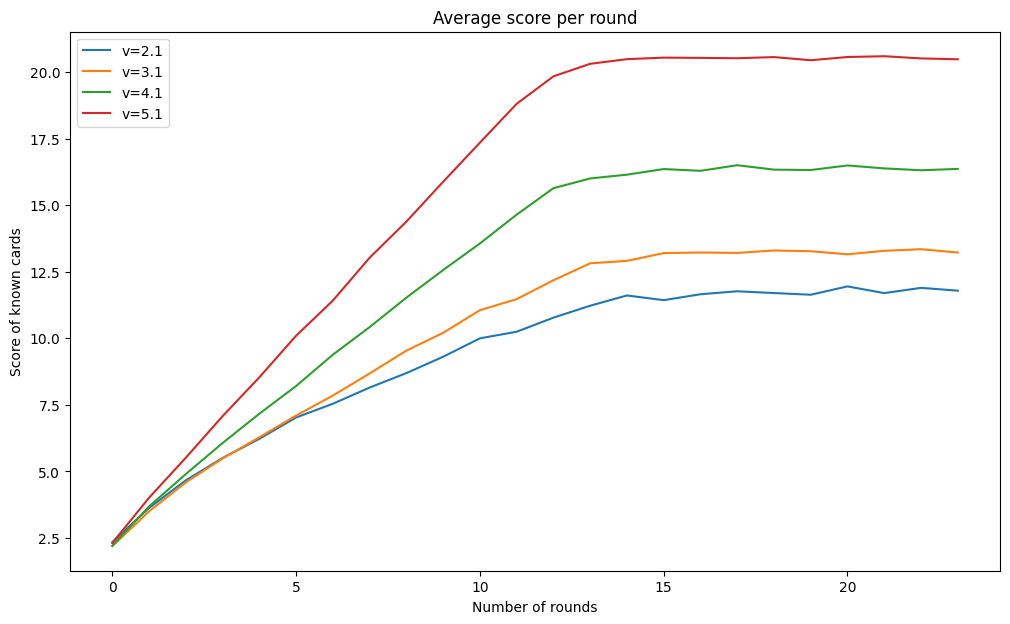

In [49]:
plt.figure(figsize=(12, 7))
plt.title("Average score per round")
for k in range(2, 6):
    plt.plot(x[k], label=f"v={k + 0.1}")
plt.xlabel("Number of rounds")
plt.ylabel("Score of known cards")
plt.legend()
plt.show()

In [21]:
def two_player_game(policy1, policy2, exp1=EXPECTED_VALUE, exp2=EXPECTED_VALUE) -> float:
    deck = Deck()
    discard_pile = DiscardPile()
    
    discard_pile.discard(deck.draw())
    board1 = PlayersBoard([deck.draw() for _ in range(12)])
    player1 = policy1(board1, deck, discard_pile, expected_value=exp1)

    board2 = PlayersBoard([deck.draw() for _ in range(12)])
    player2 = policy2(board2, deck, discard_pile, expected_value=exp2)
    
    round = 0
    while True:
        card1, position1 = player1.turn()
        
        if board1.is_finished():
            break
        
        card2, position2 = player2.turn()
        if board2.is_finished():
            break
        
        round += 1

    return board1.value(), board2.value()

In [22]:
def policy_performance_plot(ax, policy1, policy2):
    n = 10000
    deck = Deck()
    discard_pile = DiscardPile()
    
    discard_pile.discard(deck.draw())
    board1 = PlayersBoard([deck.draw() for _ in range(12)])
    player1 = policy1(board1, deck, discard_pile)

    board2 = PlayersBoard([deck.draw() for _ in range(12)])
    player2 = policy2(board2, deck, discard_pile)
    
    g = [two_player_game(policy1, policy2) for _ in range(n)]
    avg_x = round(np.average([x for x, _ in g]), 2)
    avg_y = round(np.average([y for _, y in g]), 2)
    
    ax.set_title(f"{player1} vs {player2}")
    ax.set_xlim([-10, 121])
    ax.set_ylim([-10, 121])
    ax.scatter([x for x, _ in g], [y for _, y in g], alpha=0.05)
    ax.scatter(avg_x, avg_y, c="red")
    ax.plot([-10, 120], [-10, 120], "--")
    ax.text(avg_x - 10, avg_y - 10, f"Average score\n {avg_x} x {avg_y}") 
    
    ax.set_xlabel(f"{player1} score")
    ax.set_ylabel(f"{player2} score")

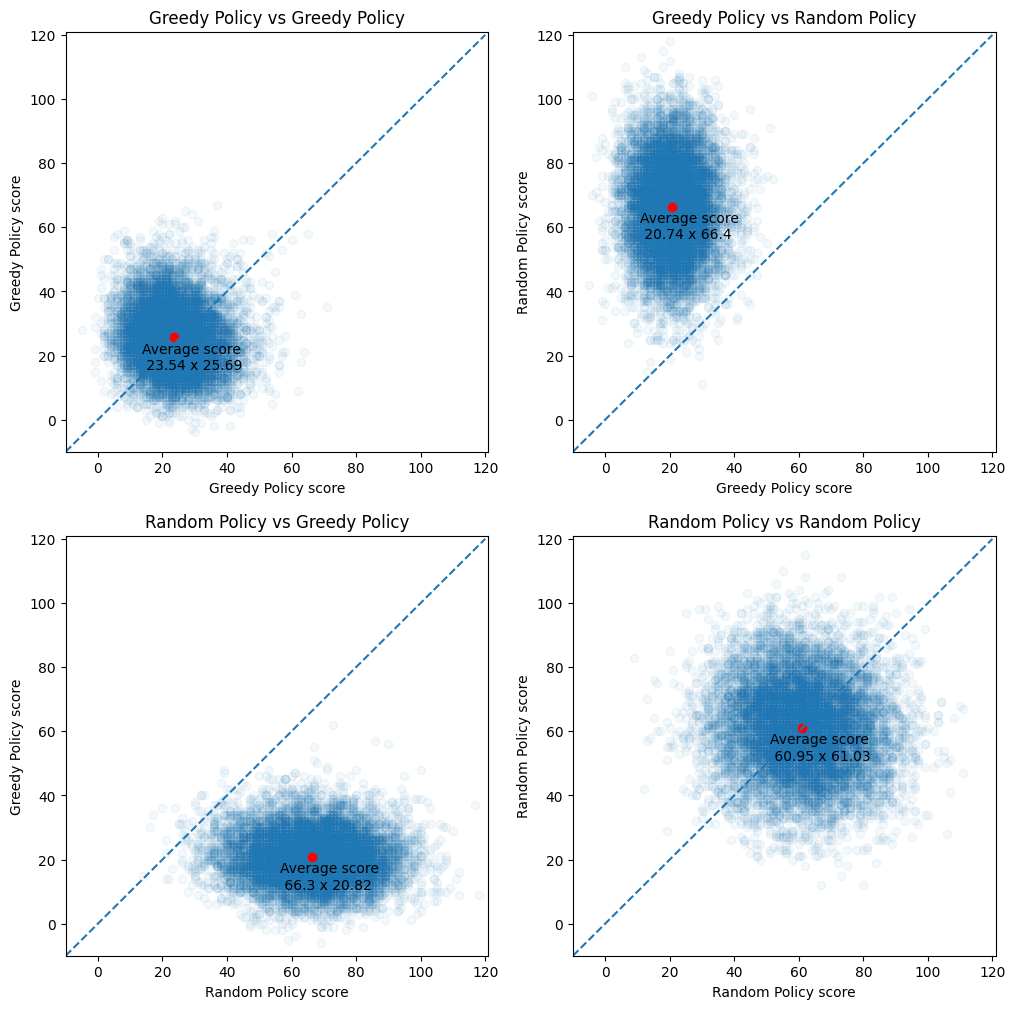

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
policy_performance_plot(ax[0, 0], GreedyPolicy, GreedyPolicy)
policy_performance_plot(ax[0, 1], GreedyPolicy, RandomPolicy)
policy_performance_plot(ax[1, 0], RandomPolicy, GreedyPolicy)
policy_performance_plot(ax[1, 1], RandomPolicy, RandomPolicy)

## Tweaking max card to draw
Greedy policy is based on accepting or refusing a card from discard and deck piles. Default strategy is to accept cards with values below expected value $\mathbb{E}(X)$. A resonable question would it be, is this really the best value to target for? How does the expected score changes for different values? How does the updated strategy change the expected score for two Greedy players?

In [24]:
n = 10 ** 4

games = {
    k: np.array([game(k + 0.1) for _ in range(n)]) for k in range(2, 8)
}
avg_scores = {
    k: np.cumsum(games[k]) / np.arange(1, n + 1)  for k in range(2, 8)
}

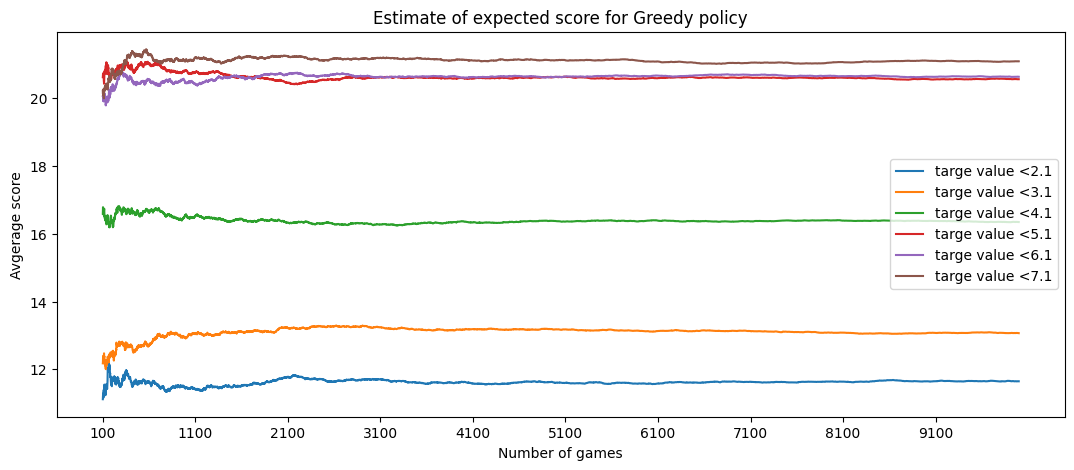

In [25]:
plt.figure(figsize=(13, 5))
plt.title("Estimate of expected score for Greedy policy")
plt.xlabel("Number of games")
plt.ylabel("Avgerage score")
plt.xticks(np.arange(100, n + 100, step=n / 10))

for k in range(2, 8):
    plt.plot(np.arange(100, n), avg_scores[k][100:], label=f"targe value <{k + 0.1}")

plt.legend()
plt.show()

In [26]:
games = {
    k: [two_player_game(GreedyPolicy, GreedyPolicy, k + 0.1) for _ in range(n)] for k in range(-2, 13)
}
games_3 = {
    k: [two_player_game(GreedyPolicy, GreedyPolicy, k + 0.1, 3.1) for _ in range(n)] for k in range(-2, 13)
}

In [27]:
avgs = {
    k: (round(np.average([x for x, _ in v]), 2), round(np.average([y for _, y in v]), 2)) for k, v in games.items()
}
avgs_3 = {
    k: (round(np.average([x for x, _ in v]), 2), round(np.average([y for _, y in v]), 2)) for k, v in games_3.items()
}

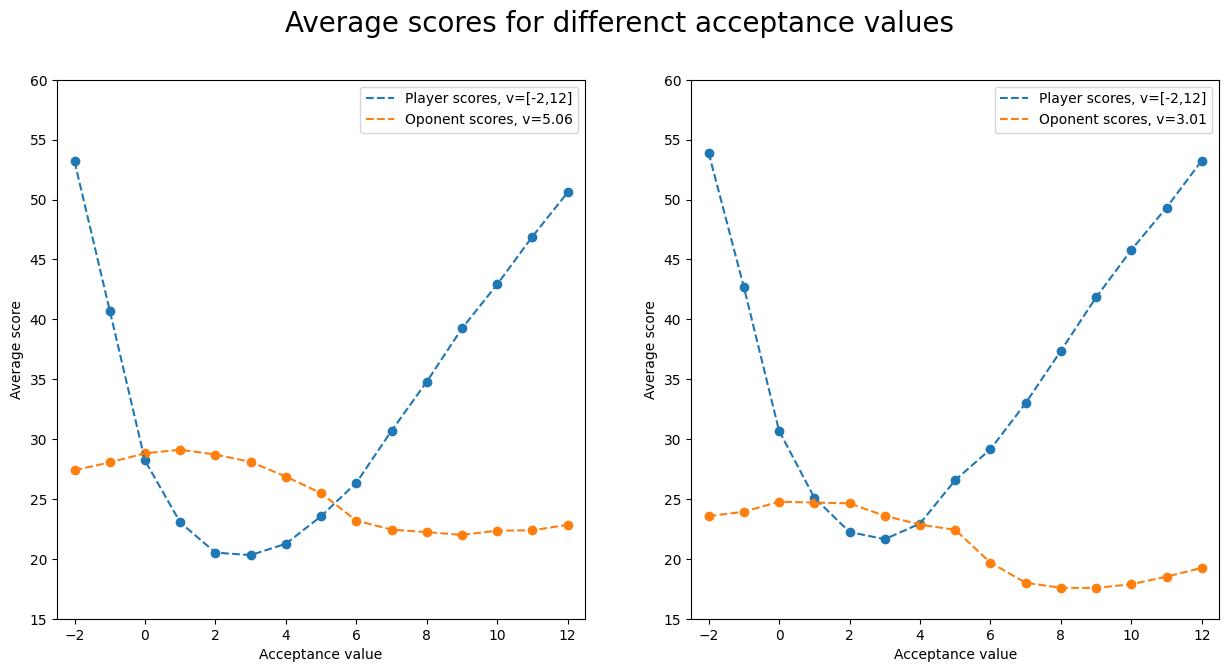

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].plot(avgs.keys(), [v[0] for v in avgs.values()], "--", label="Player scores, v=[-2,12]")
ax[0].scatter(avgs.keys(), [v[0] for v in avgs.values()])

ax[0].plot(avgs.keys(), [v[1] for v in avgs.values()], "--", label="Oponent scores, v=5.06")
ax[0].scatter(avgs.keys(), [v[1] for v in avgs.values()])

ax[1].plot(avgs_3.keys(), [v[0] for v in avgs_3.values()], "--", label="Player scores, v=[-2,12]")
ax[1].scatter(avgs_3.keys(), [v[0] for v in avgs_3.values()])

ax[1].plot(avgs_3.keys(), [v[1] for v in avgs_3.values()], "--", label="Oponent scores, v=3.01")
ax[1].scatter(avgs_3.keys(), [v[1] for v in avgs_3.values()])

ax[0].set_xlabel("Acceptance value")
ax[0].set_ylabel("Average score")
ax[0].set_xlim([-2.5, 12.5])
ax[0].set_ylim([15, 60])

ax[1].set_xlabel("Acceptance value")
ax[1].set_ylabel("Average score")
ax[1].set_xlim([-2.5, 12.5])
ax[1].set_ylim([15, 60])


fig.suptitle("Average scores for differenct acceptance values", fontsize=20)
ax[1].legend(loc="upper right")
ax[0].legend(loc="upper right")
plt.show()